Group 1 with 5 images:


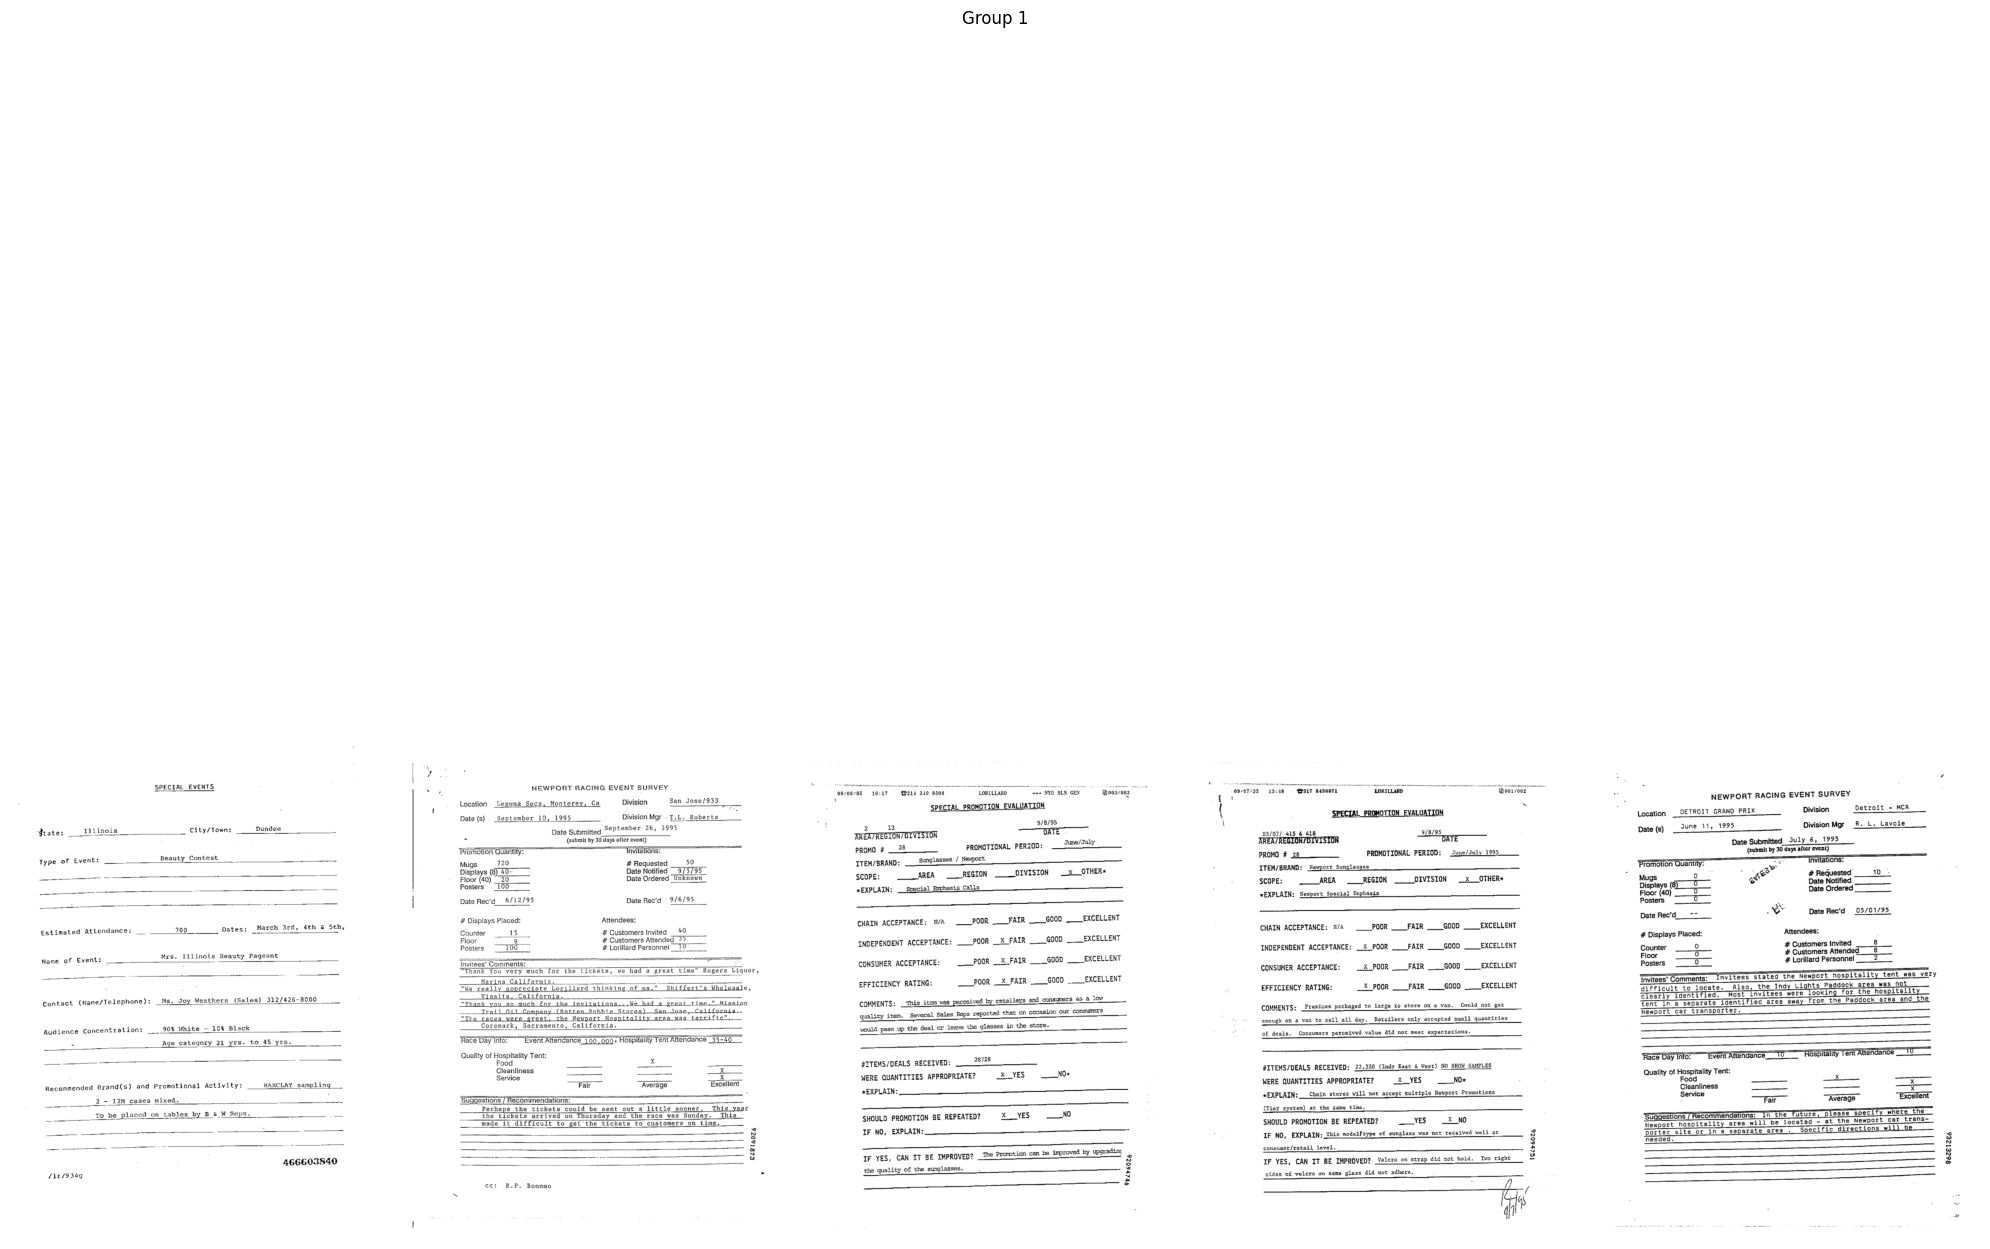

Group 2 with 2 images:


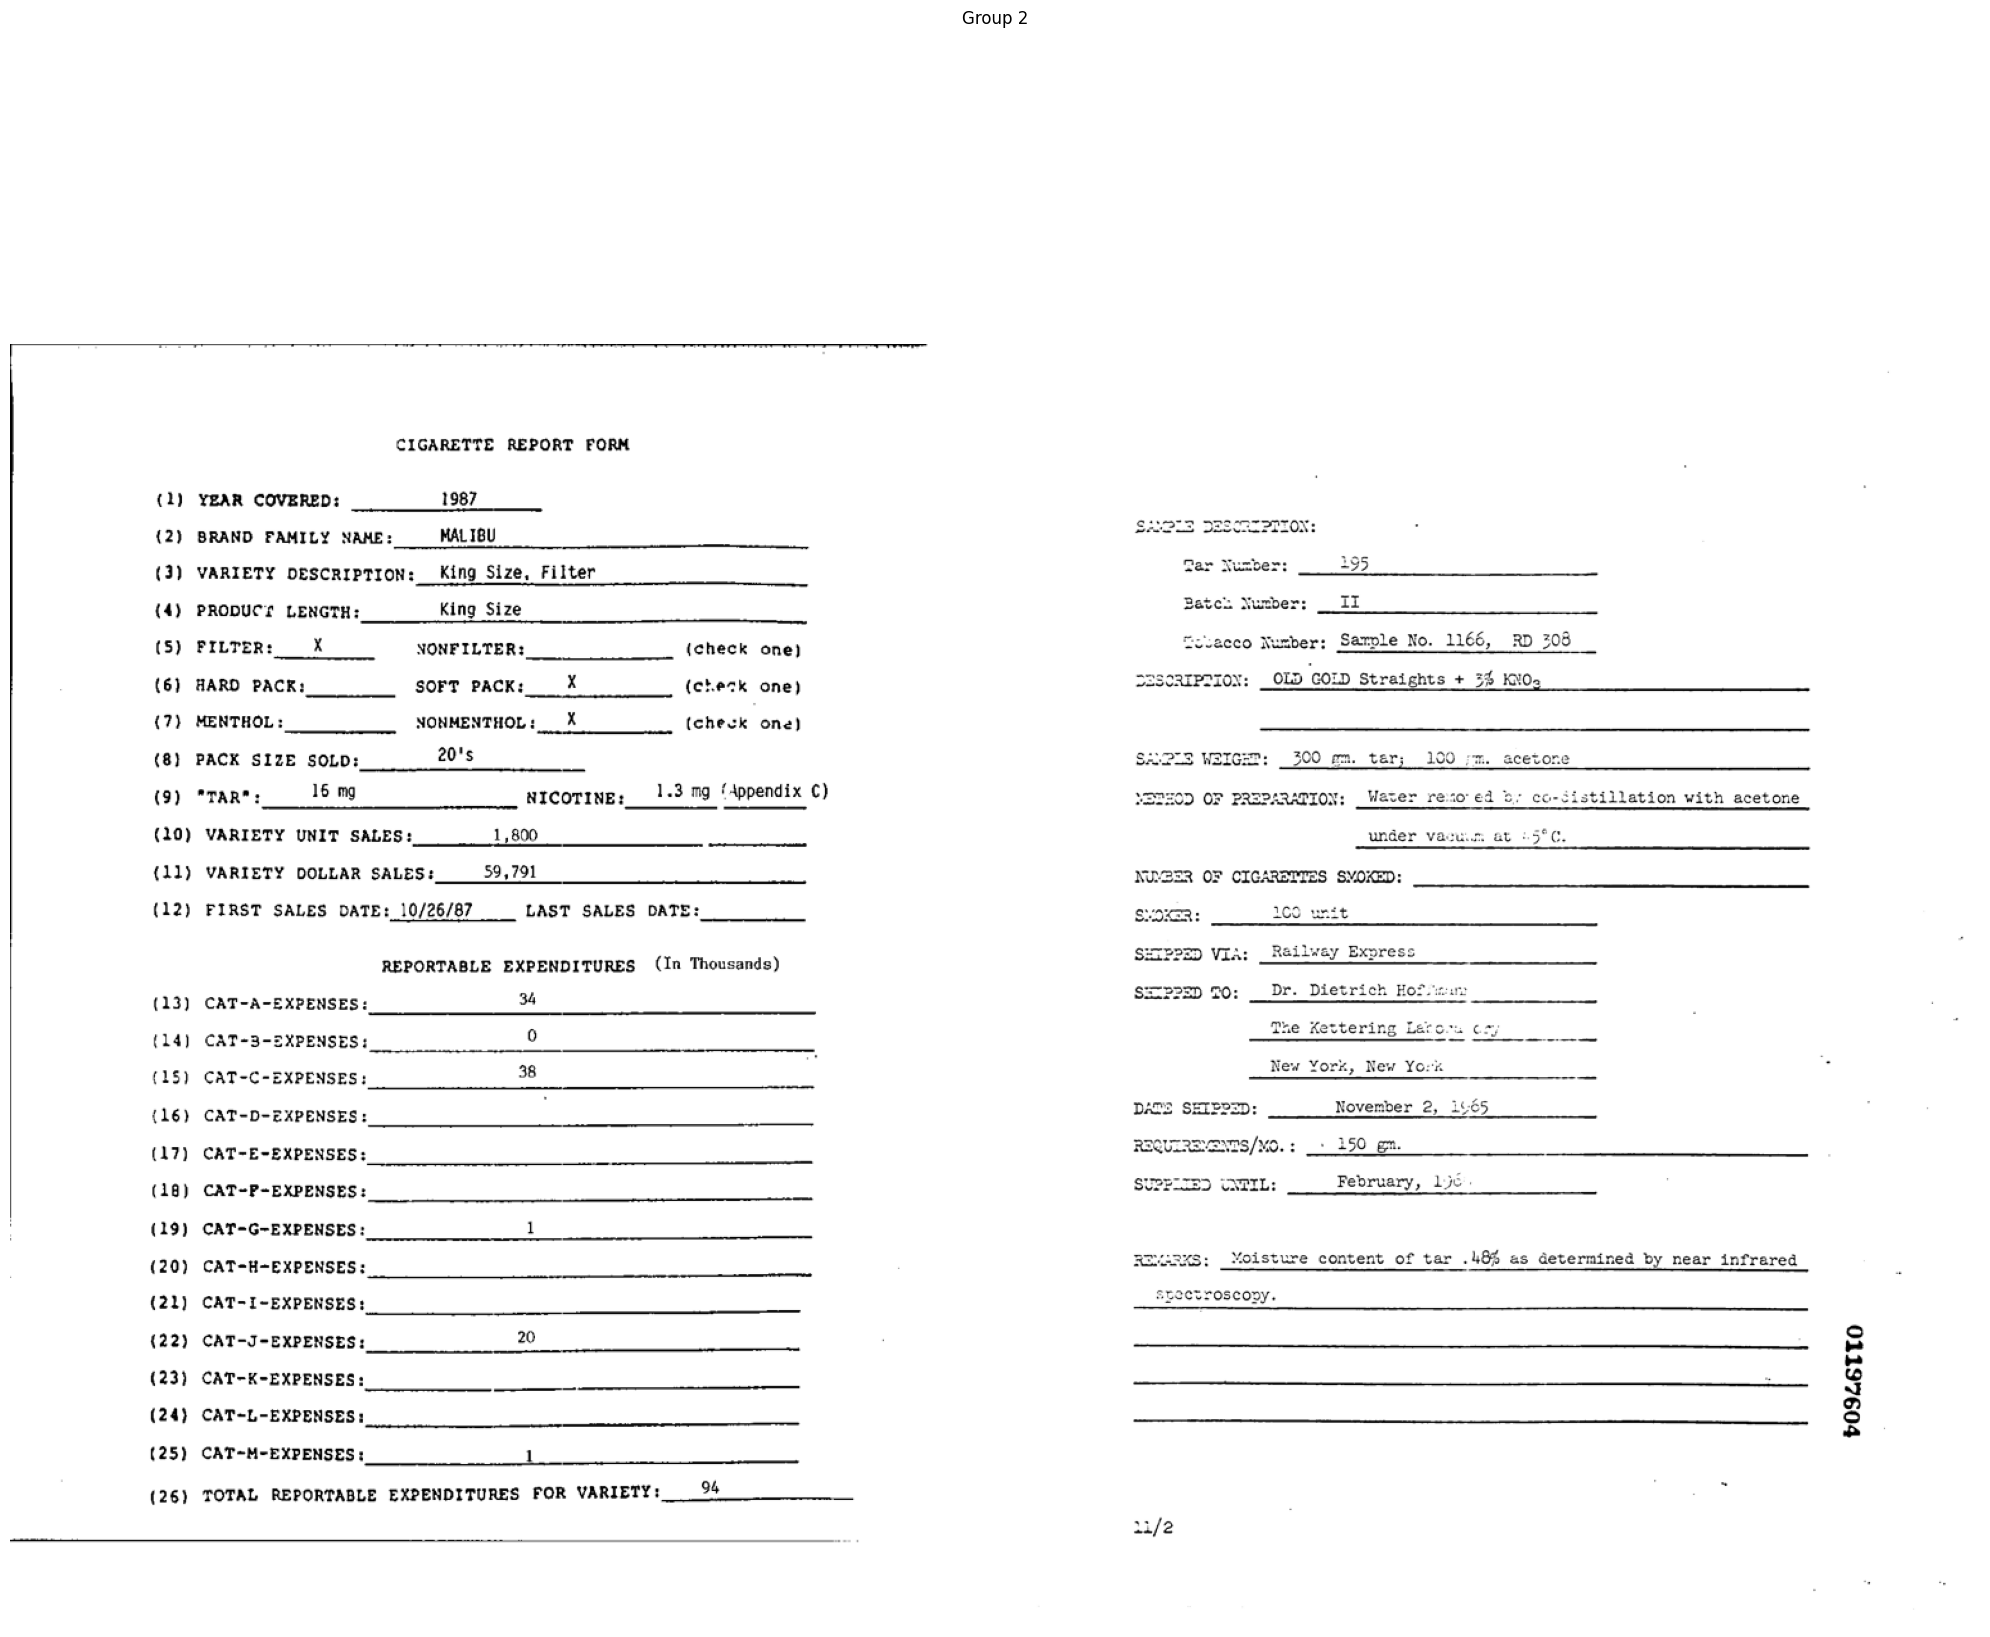

Group 3 with 2 images:


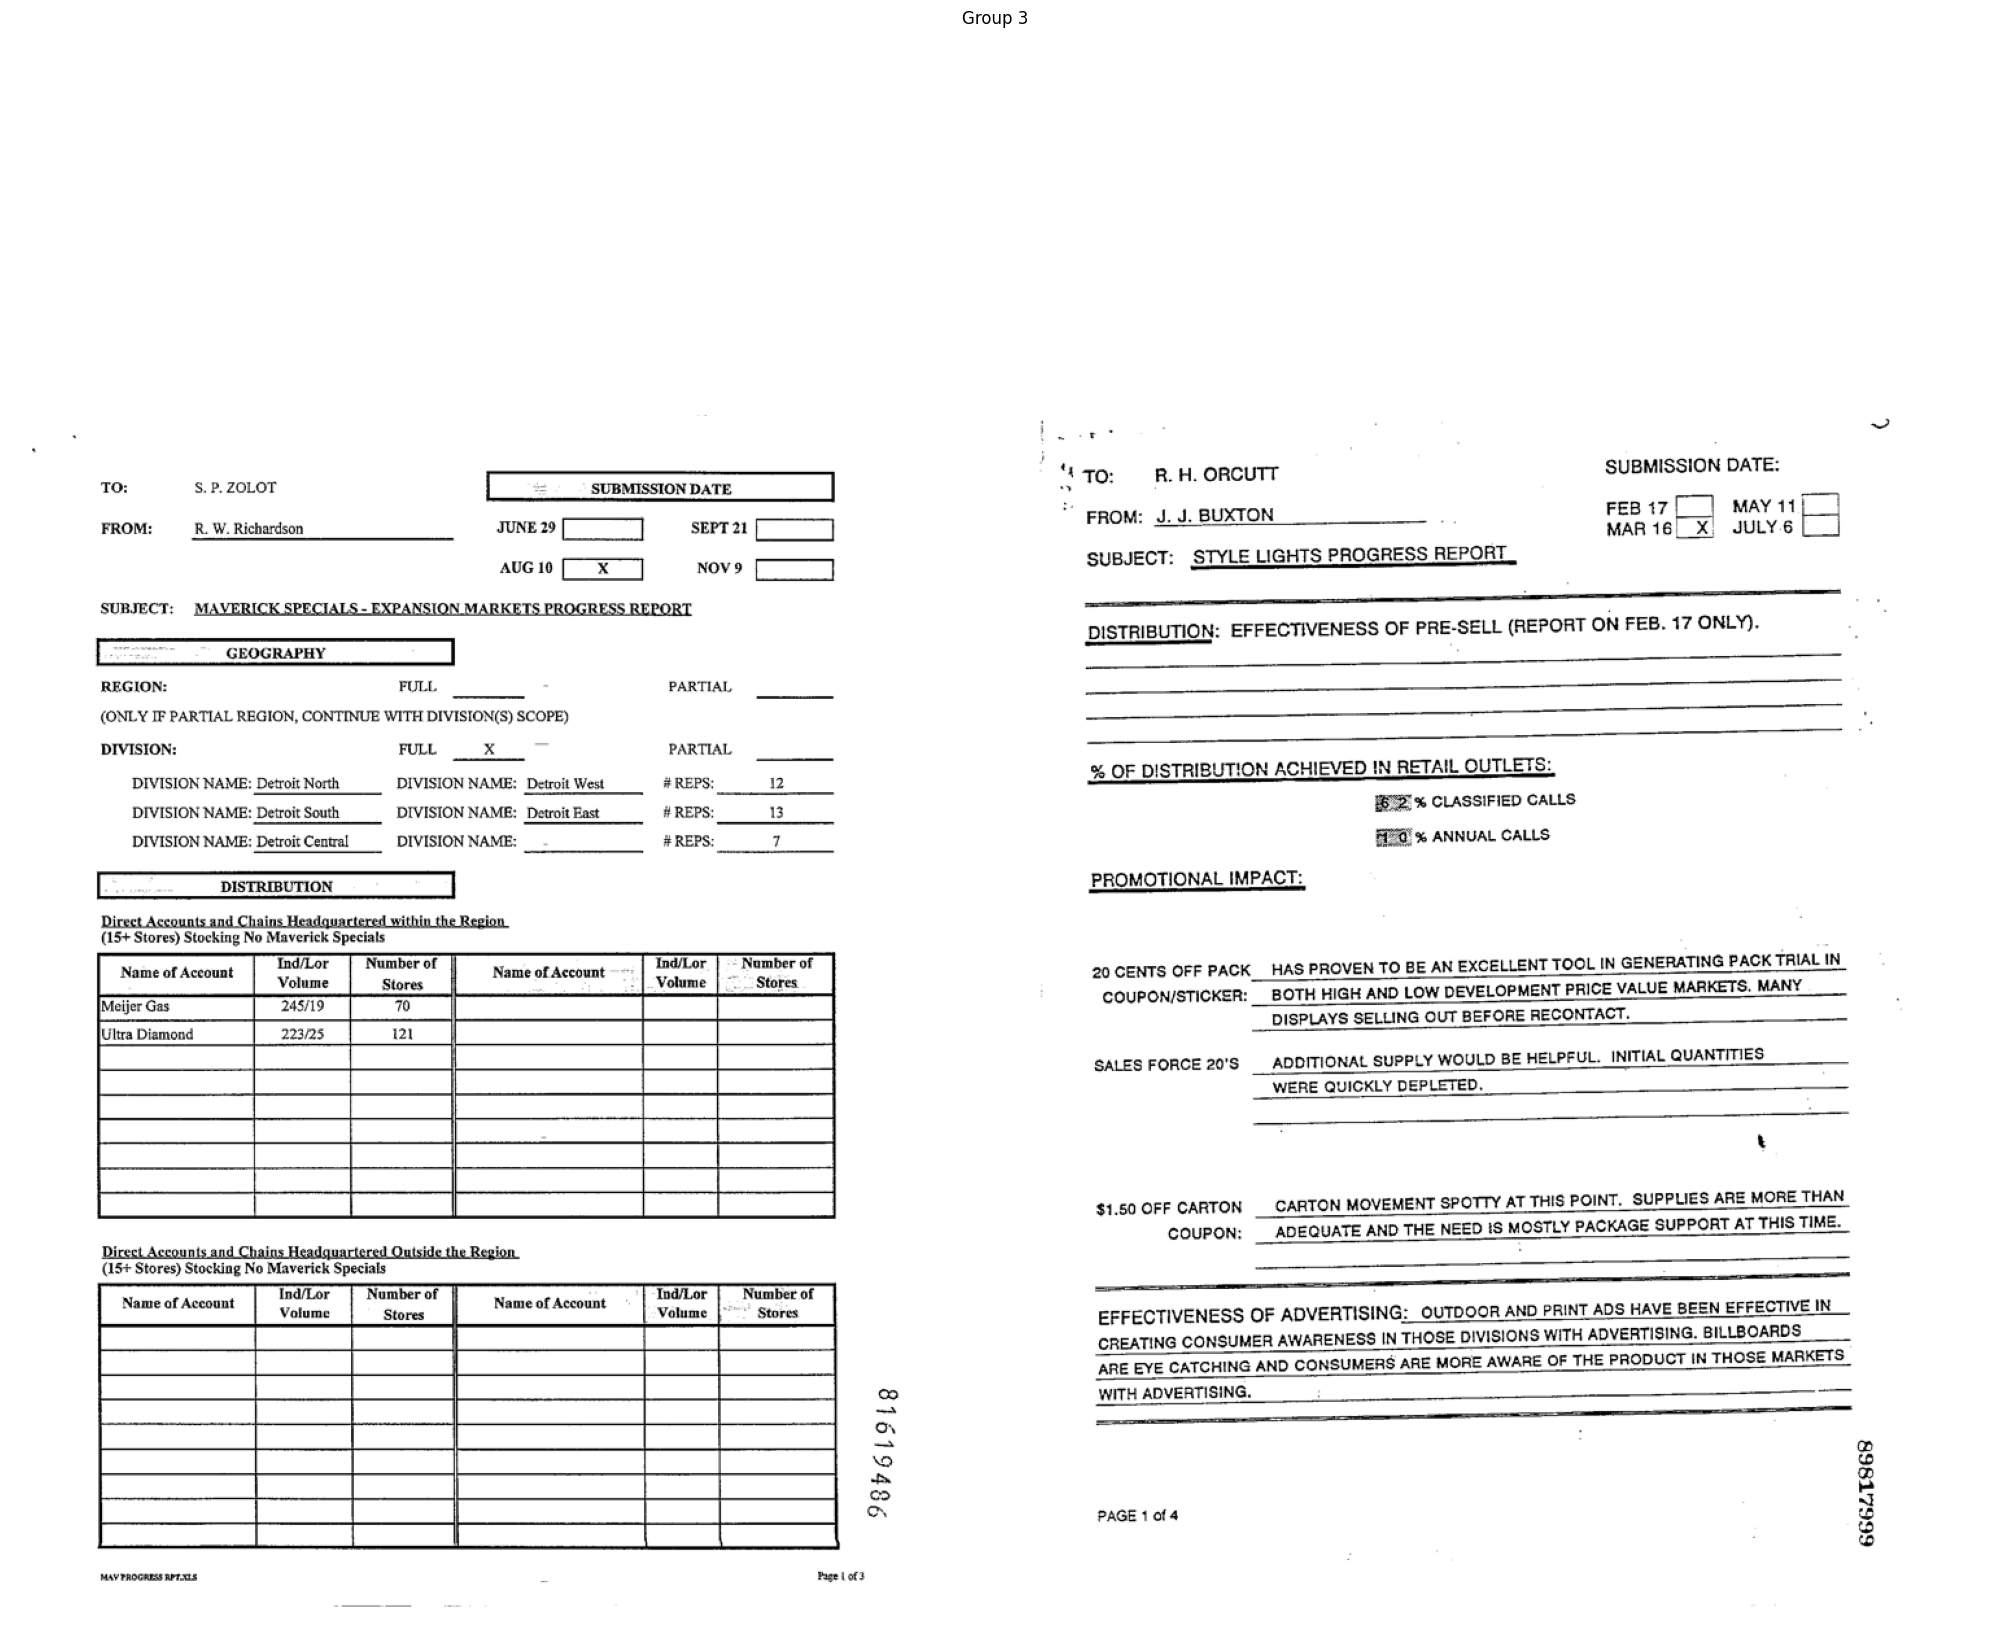

Group 4 with 2 images:


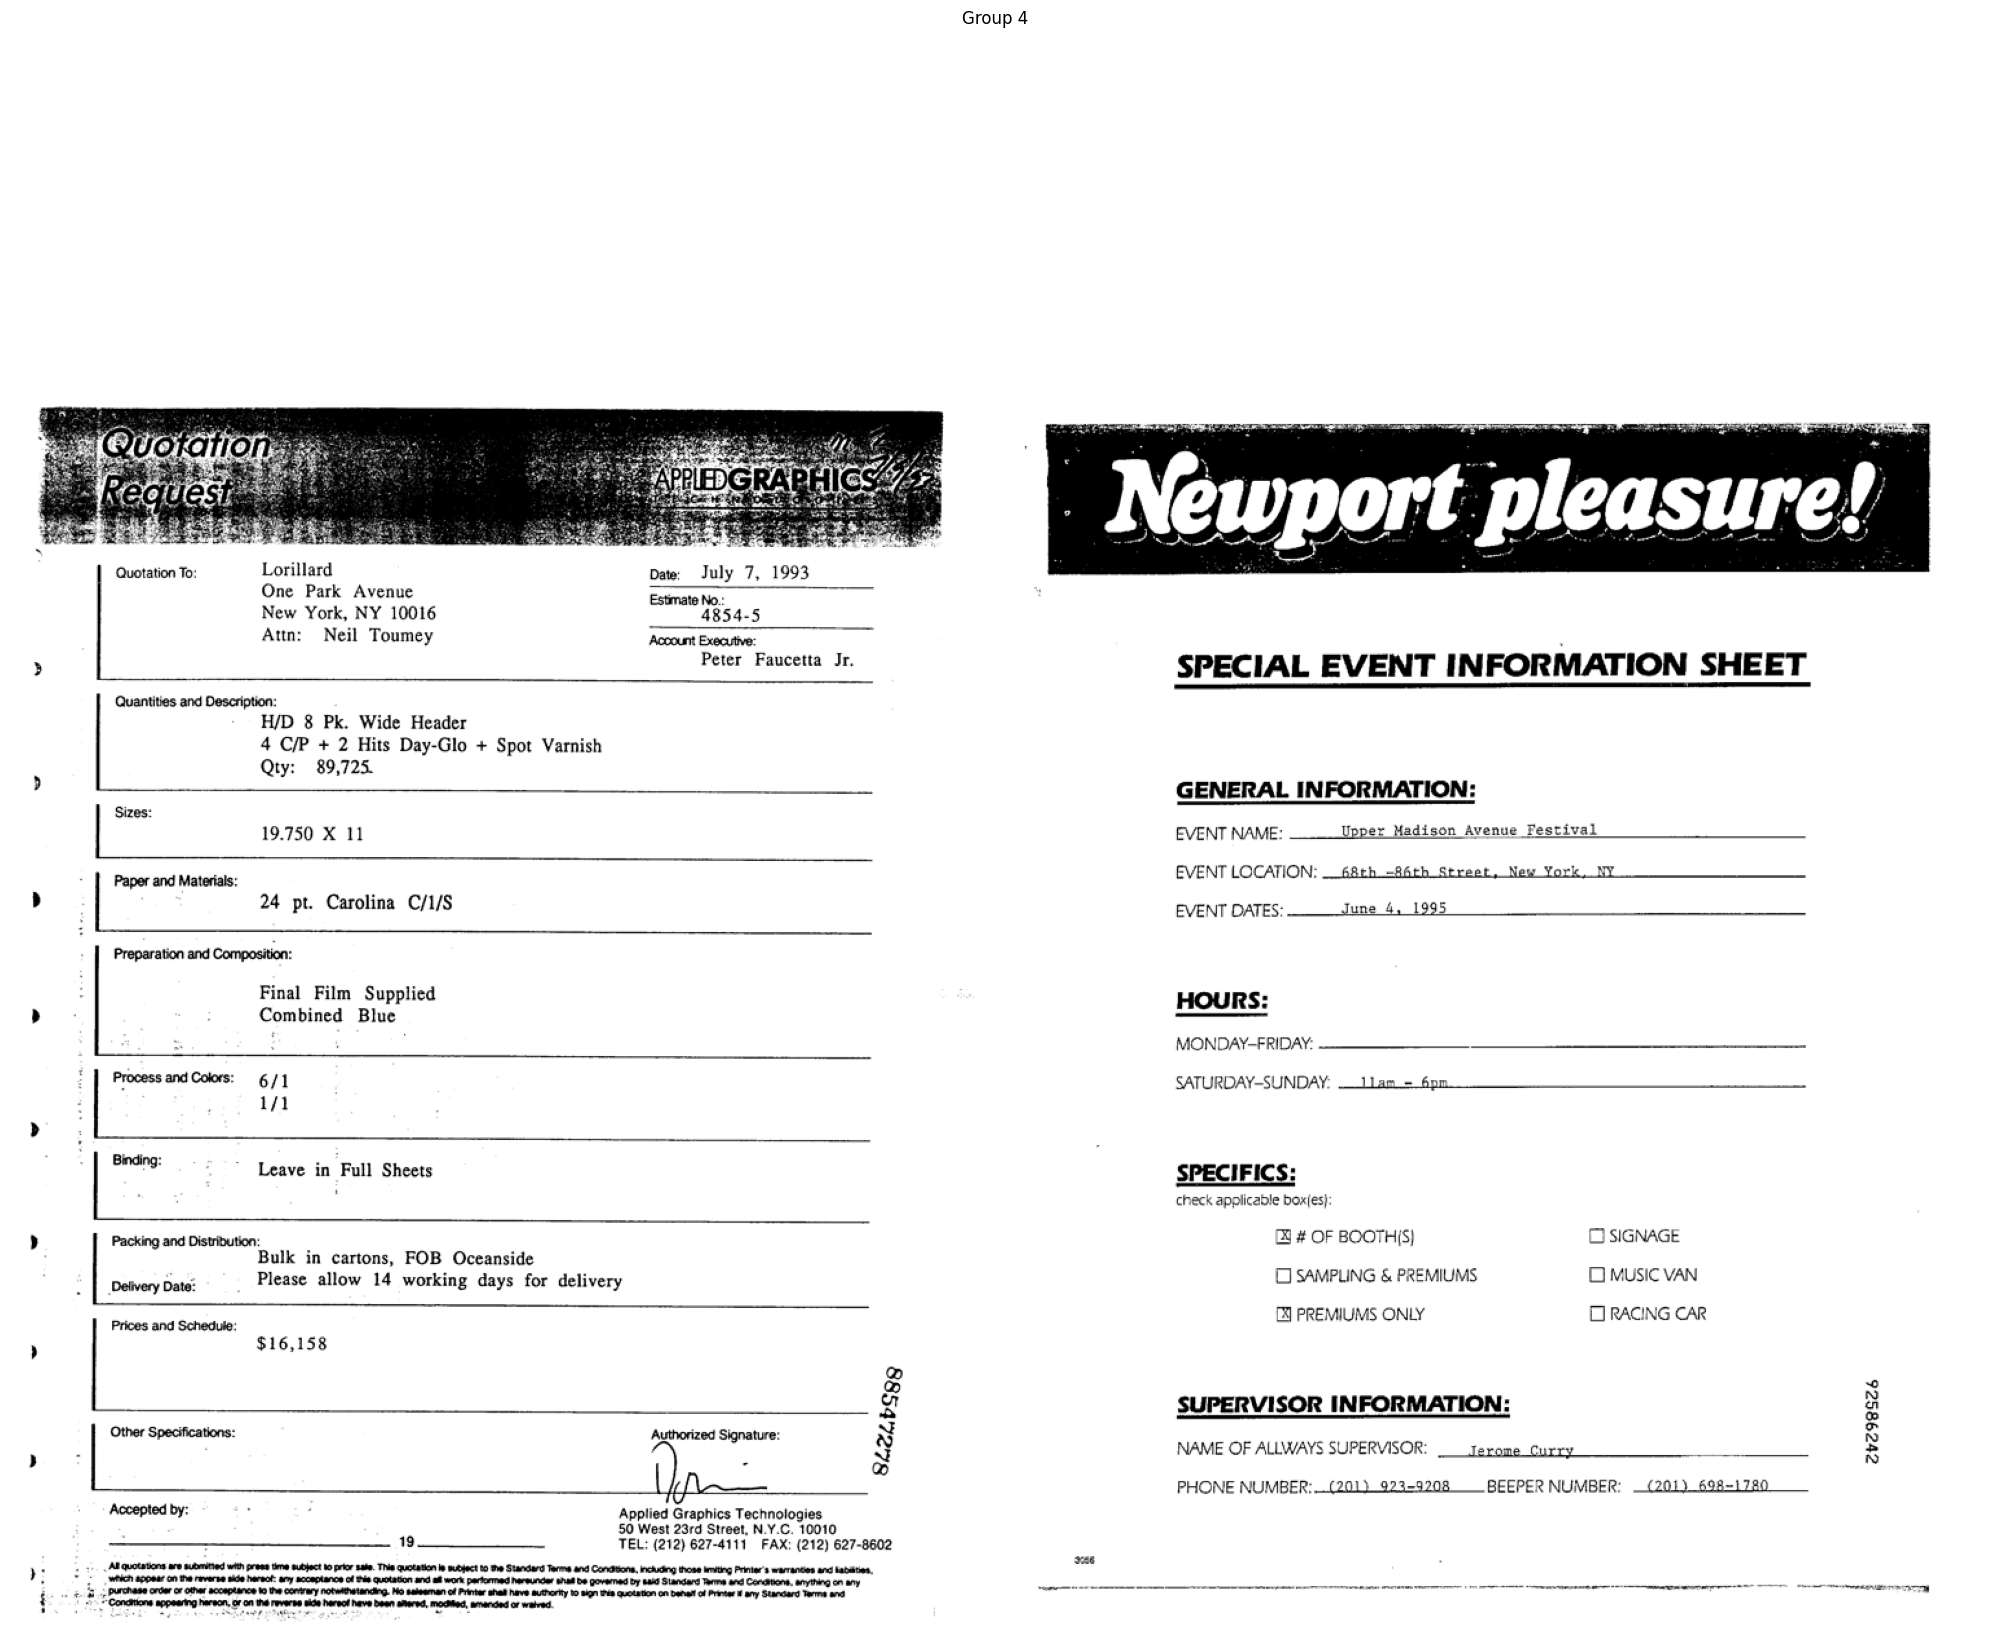

Group 5 with 2 images:


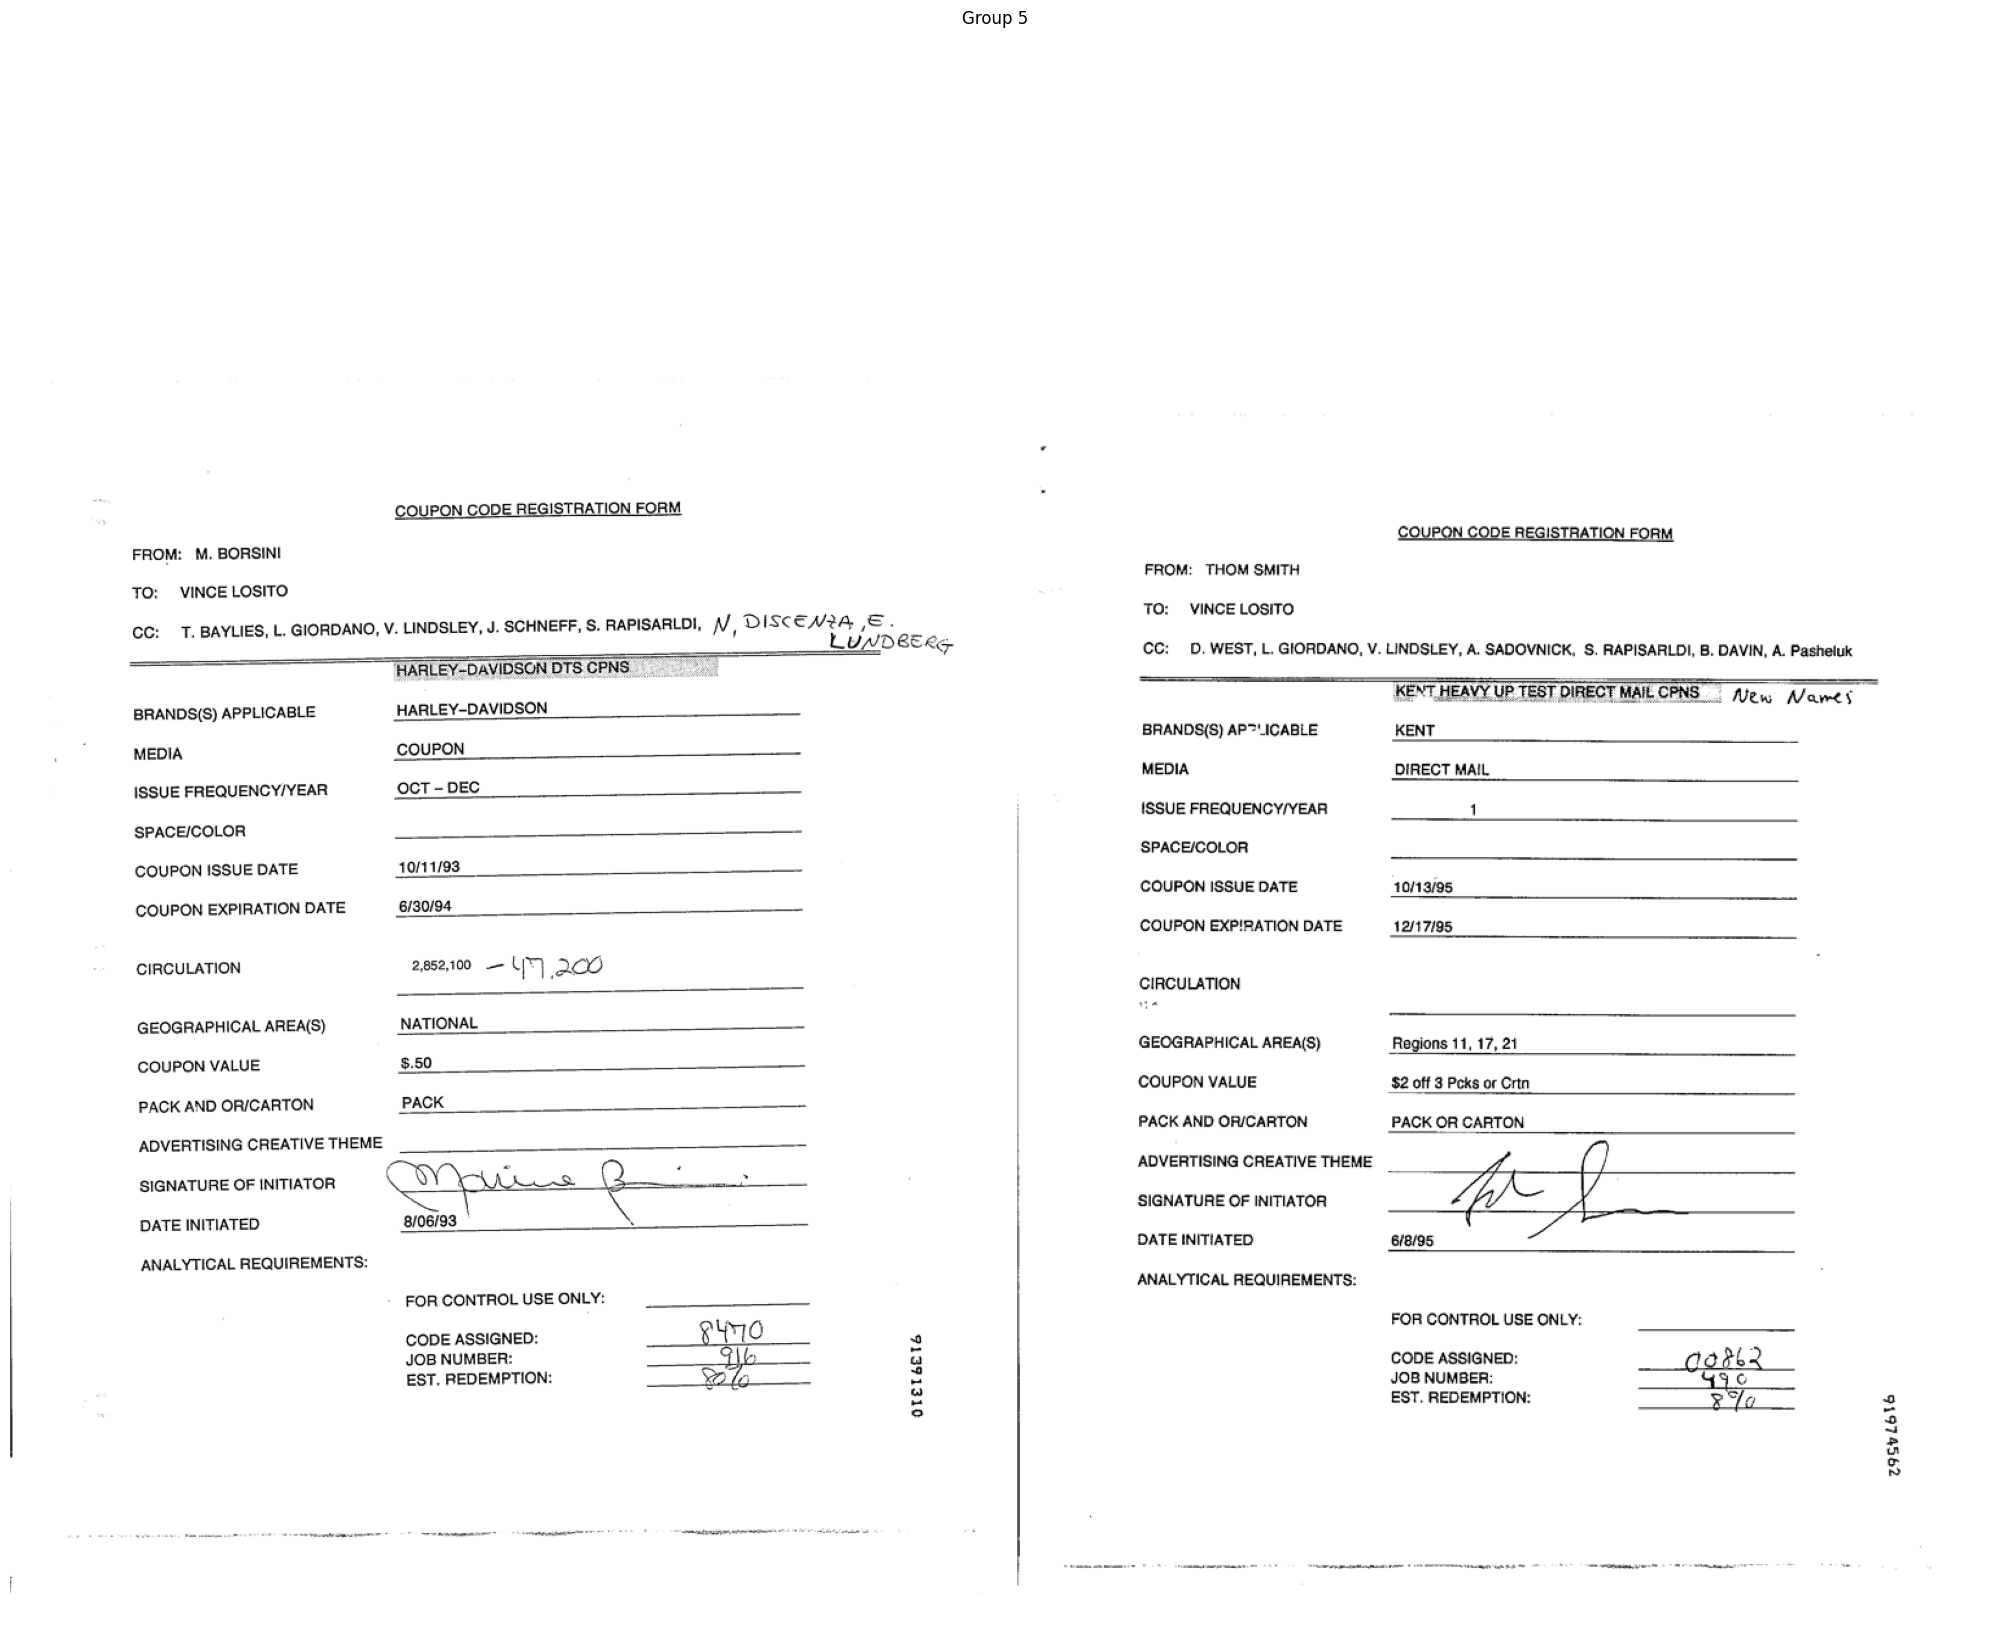

In [12]:
#templates in training dataset
import os
from PIL import Image
import imagehash
import matplotlib.pyplot as plt
from collections import defaultdict

def group_similar_images(image_dir, hash_func=imagehash.average_hash, hash_size=8, sim_threshold=5, top_n=4):
    images = []
    hashes = []

    # Load and hash all images
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        try:
            with Image.open(img_path) as img:
                img_hash = hash_func(img, hash_size)
                images.append((img_path, img_hash))
        except IOError:
            print(f"Skipping non-image file: {img_path}")
            continue

    # Group images based on hash similarity
    groups = []
    for img_path, img_hash in images:
        found = False
        for group in groups:
            if any(img_hash - other_hash <= sim_threshold for _, other_hash in group):
                group.append((img_path, img_hash))
                found = True
                break
        if not found:
            groups.append([(img_path, img_hash)])

    # Sort groups by size
    groups.sort(key=len, reverse=True)

    # Display top n groups
    for group_idx, group in enumerate(groups[:top_n]):
        if len(group) < 2:
            # Skip groups with less than 2 similar images
            continue
        print(f"Group {group_idx + 1} with {len(group)} images:")
        fig, axs = plt.subplots(1, min(len(group), 10),figsize=(20, 20))
        fig.suptitle(f'Group {group_idx + 1}')
        for img_idx, (img_path, _) in enumerate(group[:10]):
            img = Image.open(img_path)
            img = img.convert("RGB")
            if len(group) > 1:
                axs[img_idx].imshow(img)
                axs[img_idx].axis('off')
            else:
                axs.imshow(img)
                axs.axis('off')
        # Adjust layout
        plt.tight_layout()
        # Save the figure with the bbox_inches parameter to include all content
        plt.savefig(f'group_{group_idx + 1}.png', bbox_inches='tight')
        plt.show()

# Example usage
image_directory = "C:\\Users\\arpit\\Desktop\\UG\\Masters\\Datasets\\FUNSD\\training_data\\images"
group_similar_images(image_directory, hash_func=imagehash.average_hash, hash_size=8, sim_threshold=4, top_n=10)


Group 1 with 2 images:


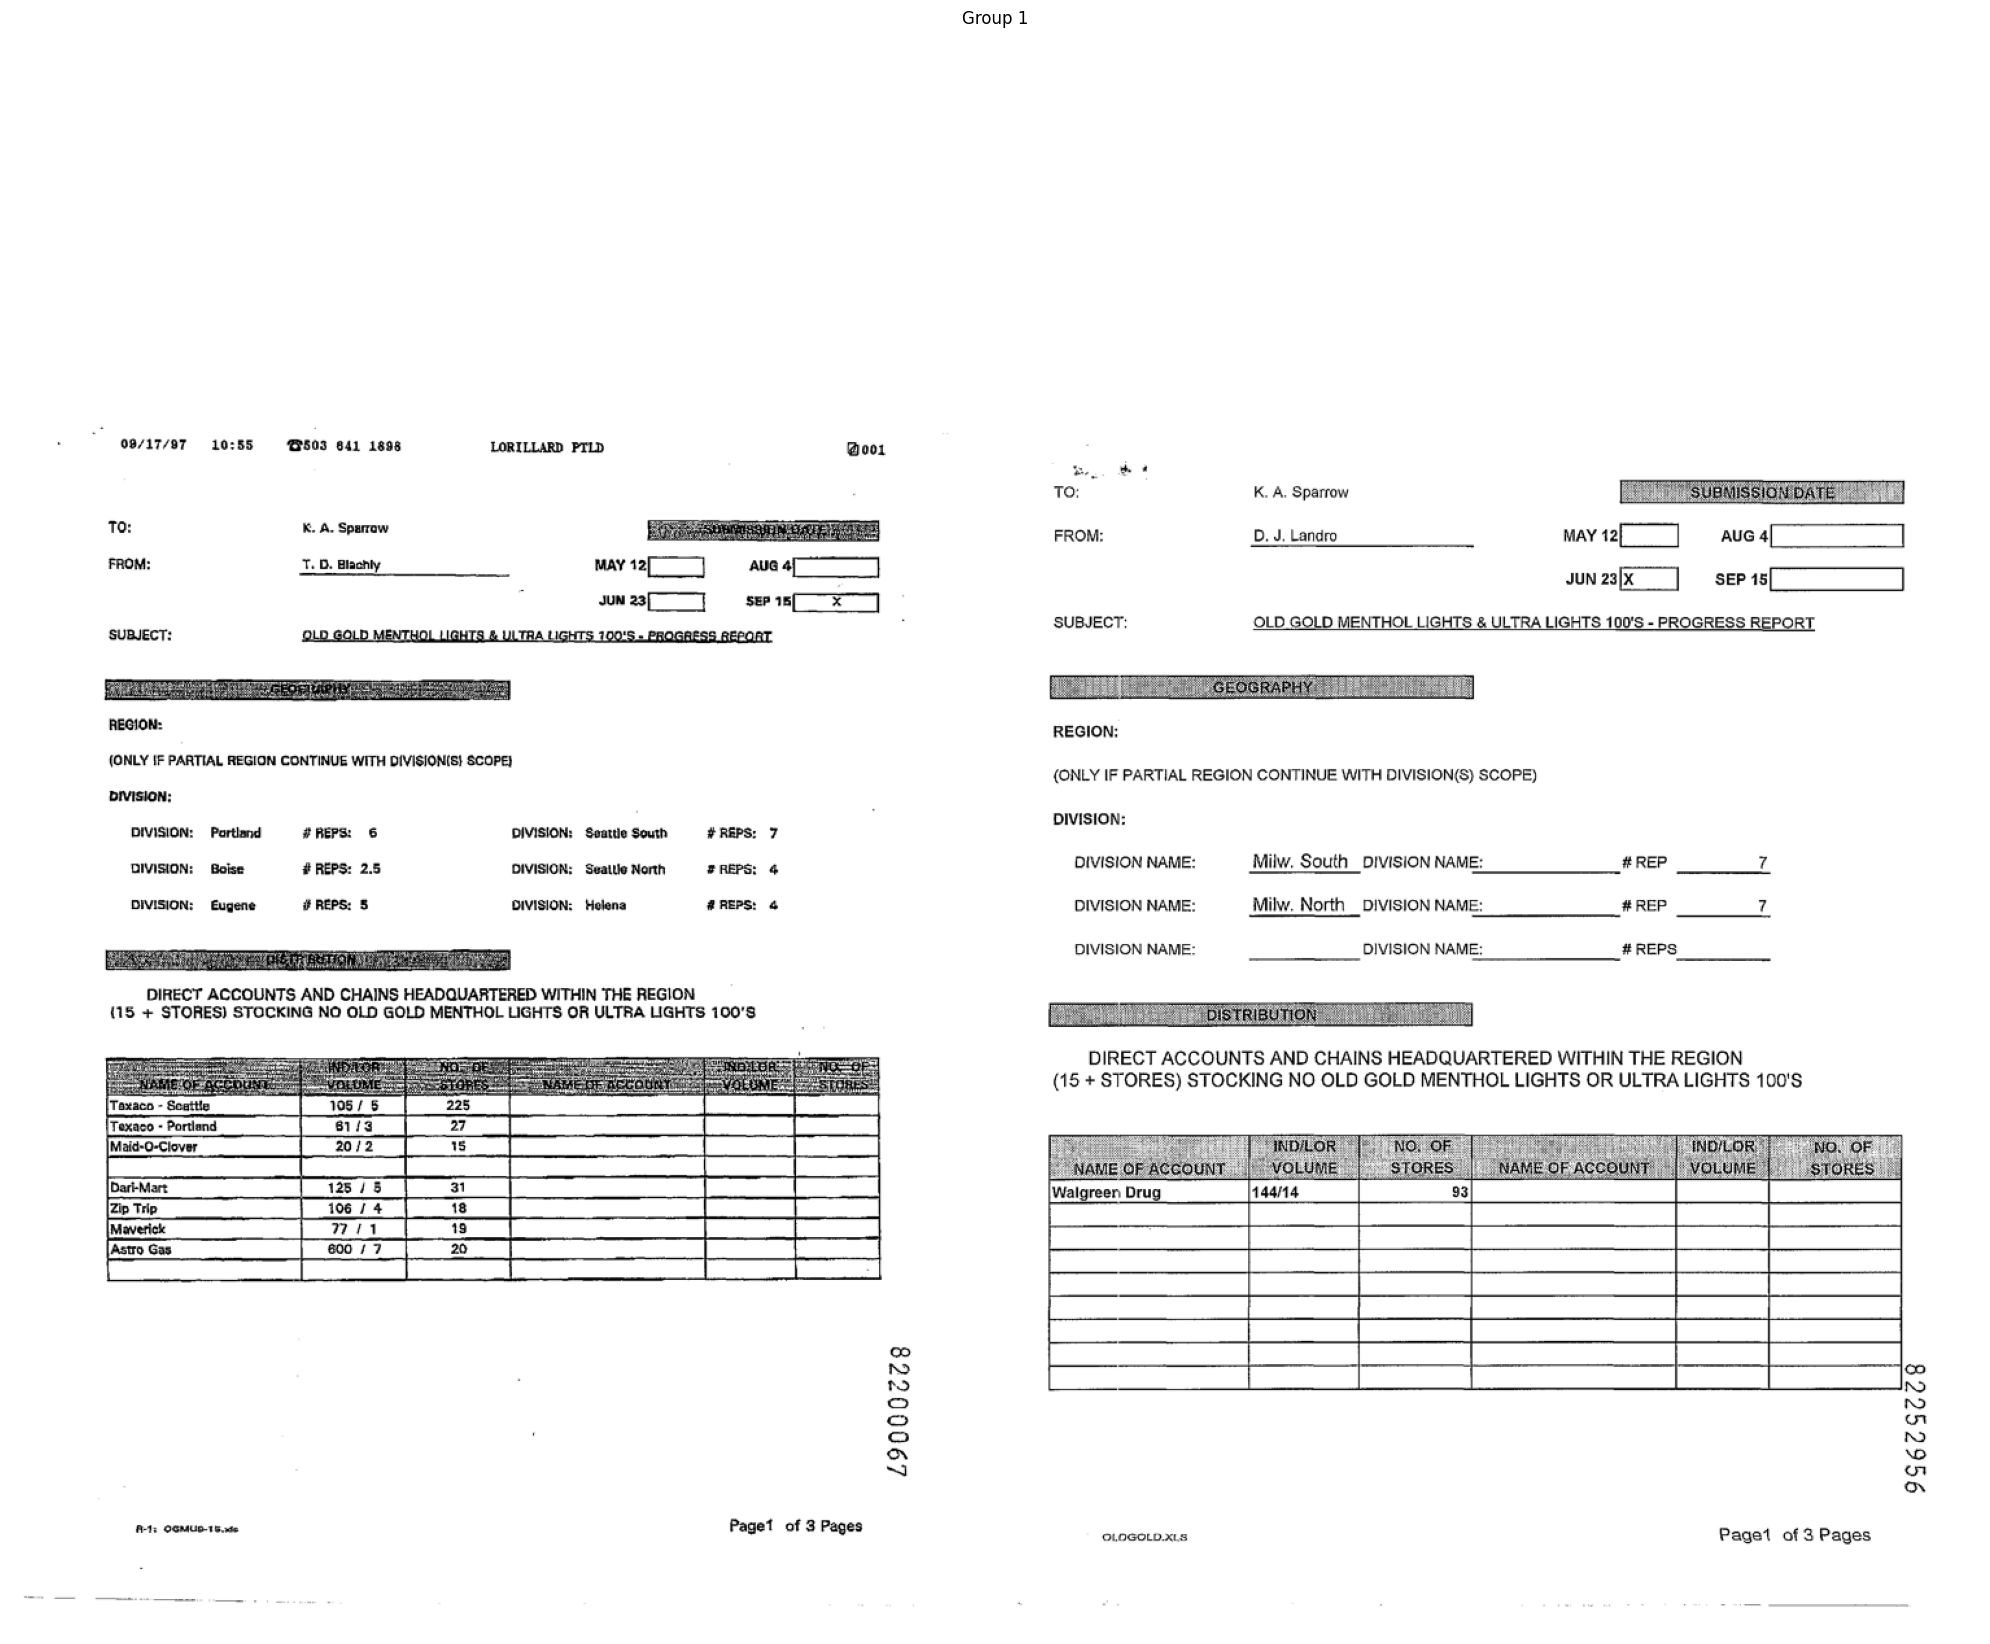

Group 2 with 2 images:


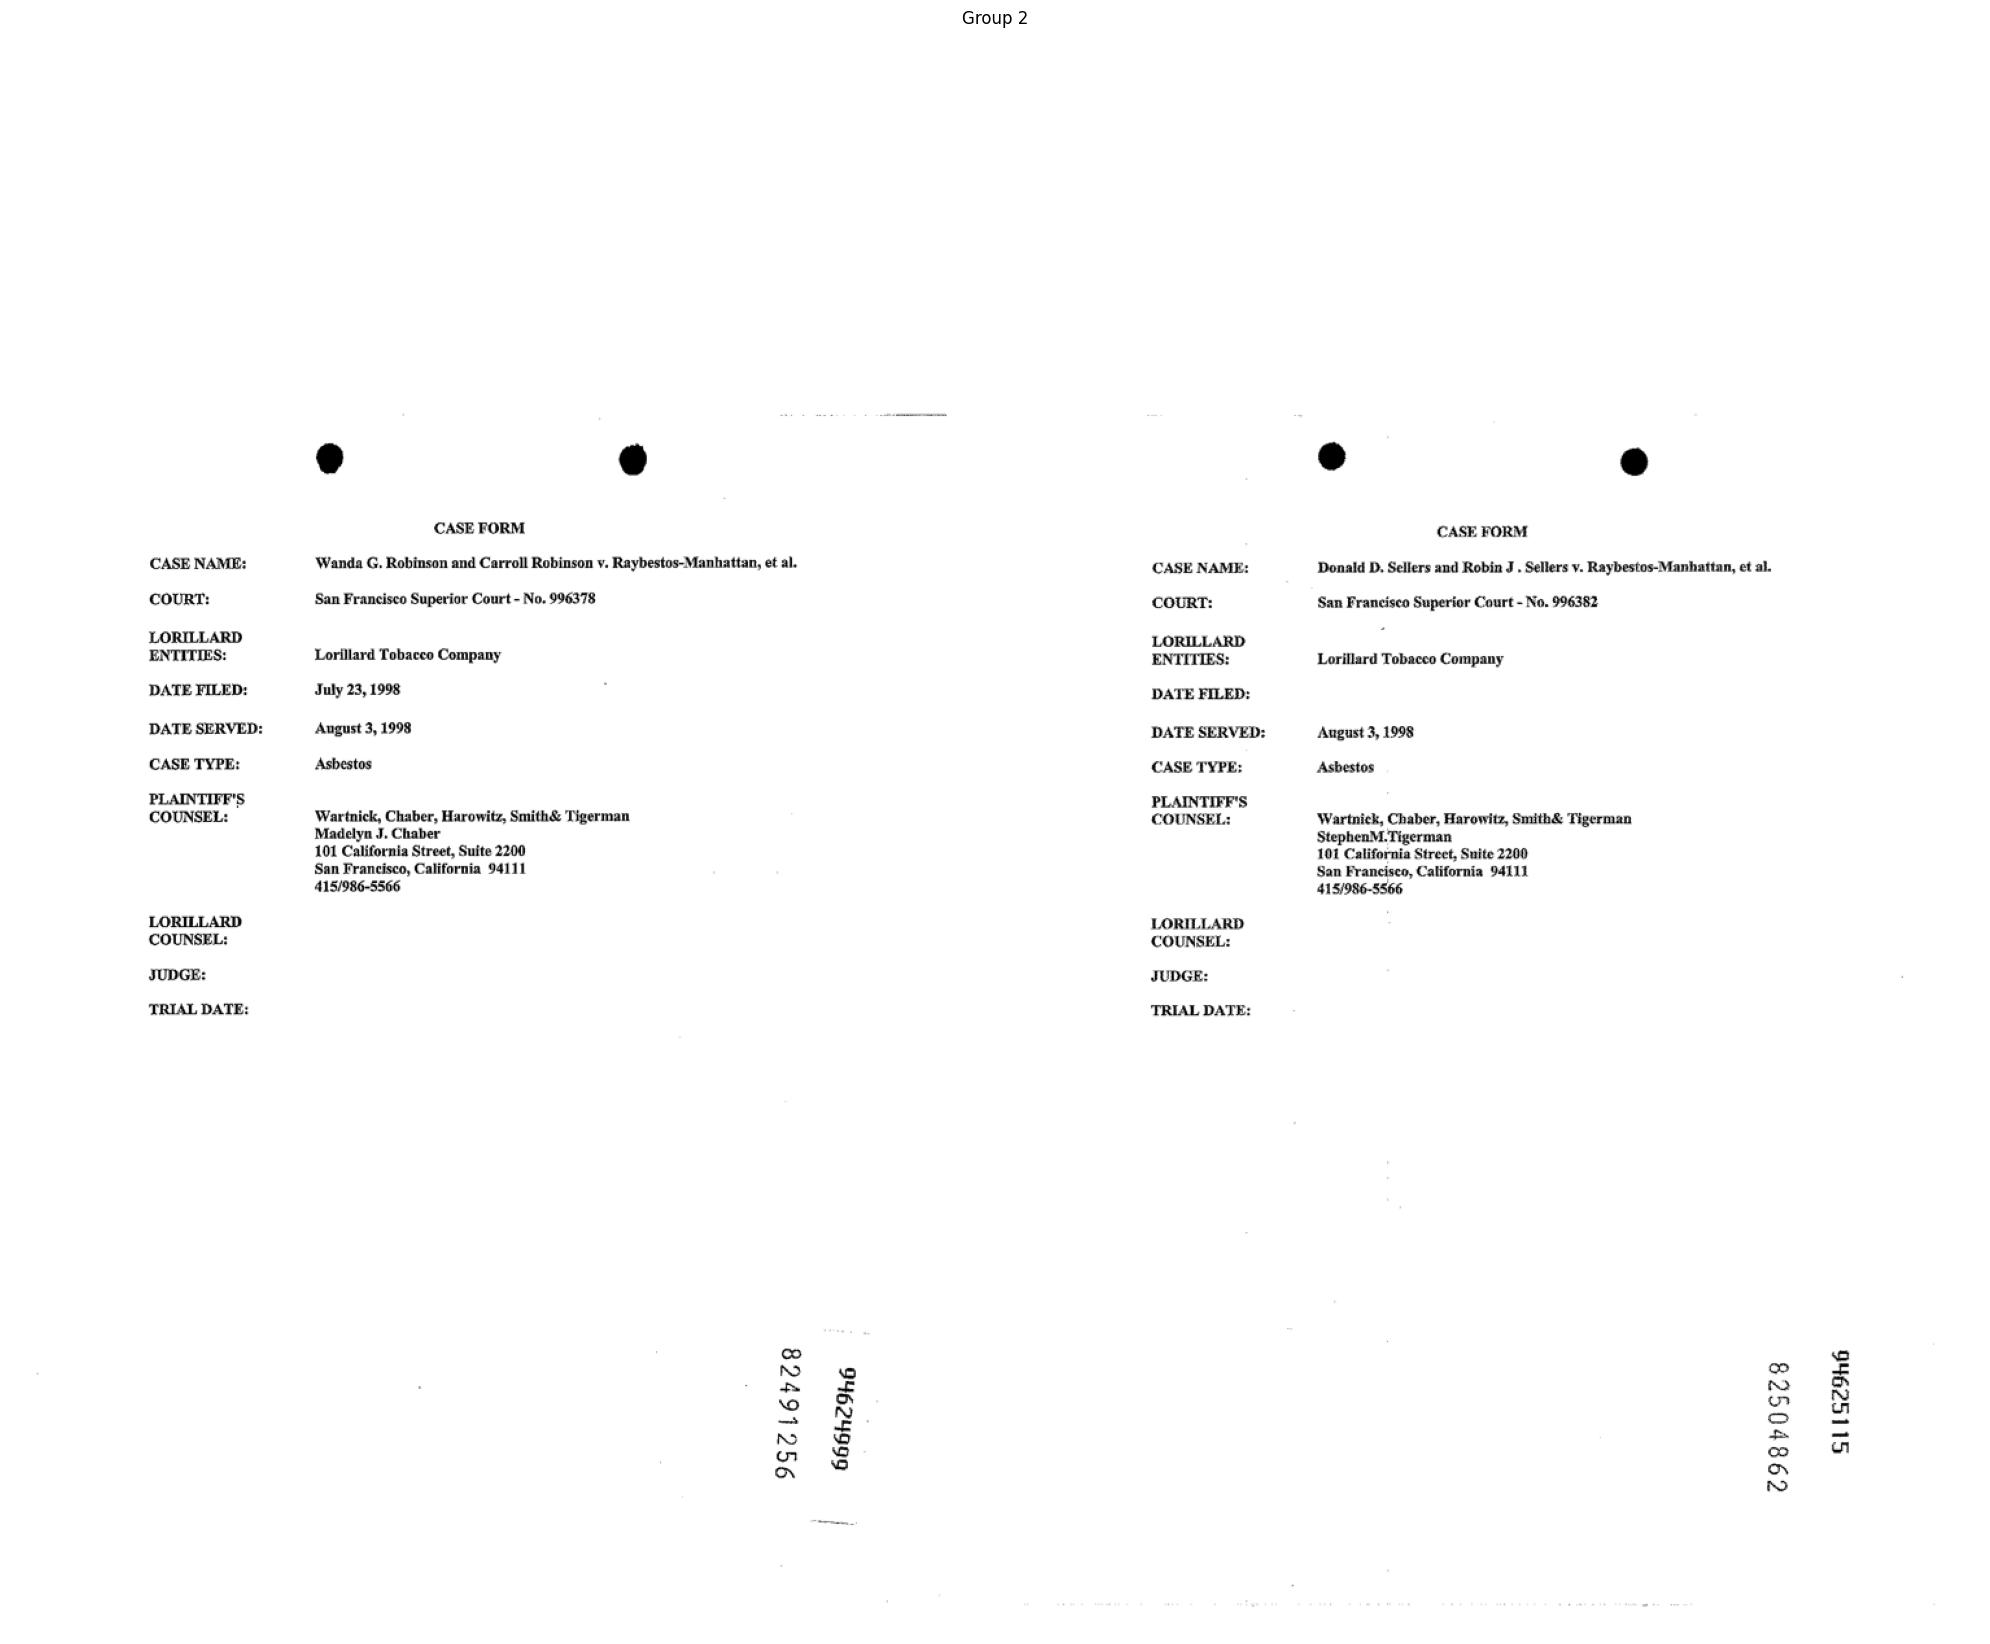

Group 3 with 2 images:


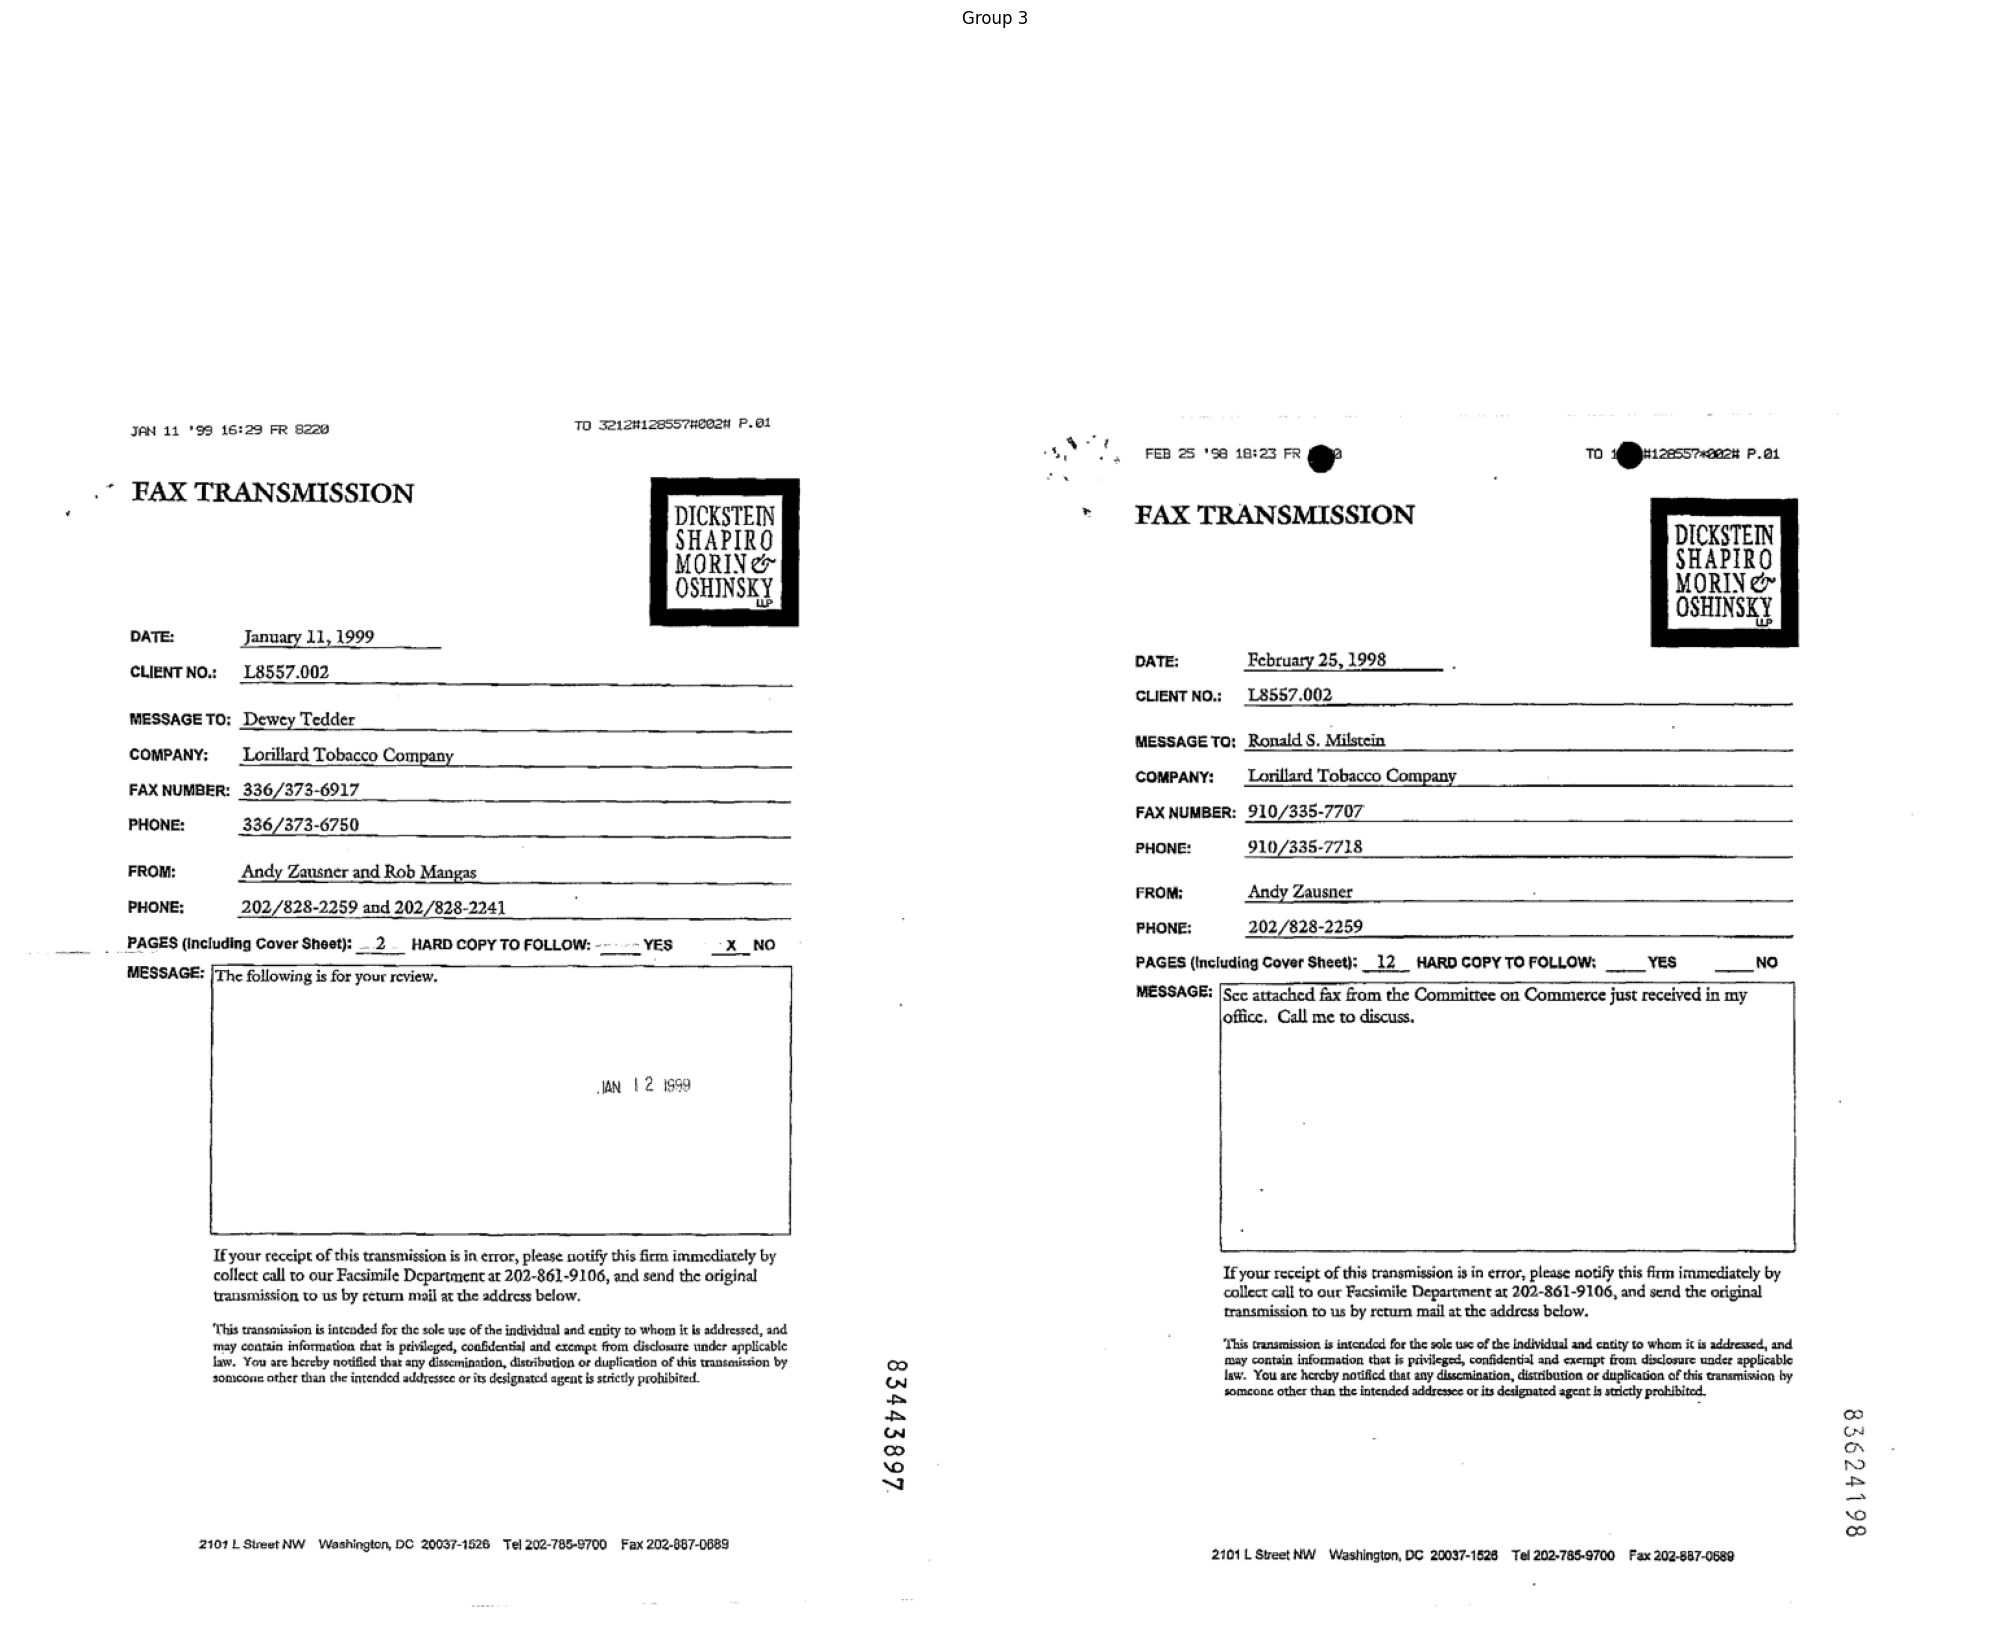

In [ ]:
#templates in test dataset
import os
from PIL import Image
import imagehash
import matplotlib.pyplot as plt
from collections import defaultdict

def group_similar_images(image_dir, hash_func=imagehash.average_hash, hash_size=8, sim_threshold=5, top_n=4):
    images = []
    hashes = []

    # Load and hash all images
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        try:
            with Image.open(img_path) as img:
                img_hash = hash_func(img, hash_size)
                images.append((img_path, img_hash))
        except IOError:
            print(f"Skipping non-image file: {img_path}")
            continue

    # Group images based on hash similarity
    groups = []
    for img_path, img_hash in images:
        found = False
        for group in groups:
            if any(img_hash - other_hash <= sim_threshold for _, other_hash in group):
                group.append((img_path, img_hash))
                found = True
                break
        if not found:
            groups.append([(img_path, img_hash)])

    # Sort groups by size
    groups.sort(key=len, reverse=True)

    # Display top n groups
    for group_idx, group in enumerate(groups[:top_n]):
        if len(group) < 2:
            # Skip groups with less than 2 similar images
            continue
        print(f"Group {group_idx + 1} with {len(group)} images:")
        fig, axs = plt.subplots(1, min(len(group), 10),figsize=(20, 20))
        fig.suptitle(f'Group {group_idx + 1}')
        for img_idx, (img_path, _) in enumerate(group[:30]):
            img = Image.open(img_path)
            img = img.convert("RGB")
            if len(group) > 1:
                axs[img_idx].imshow(img)
                axs[img_idx].axis('off')
            else:
                axs.imshow(img)
                axs.axis('off')
        # Adjust layout
        plt.tight_layout()
        # Save the figure with the bbox_inches parameter to include all content
        plt.savefig(f'group_{group_idx + 1}.png', bbox_inches='tight')
        plt.show()

# Example usage
image_directory = "C:\\Users\\arpit\\Desktop\\UG\\Masters\\Datasets\\FUNSD\\testing_data\\images"
group_similar_images(image_directory, hash_func=imagehash.average_hash, hash_size=8, sim_threshold=5, top_n=10)


In [1]:
import cv2
import numpy as np
import os
from sklearn.cluster import DBSCAN
from collections import defaultdict

def feature_based_grouping(image_dir, min_samples=1):
    # ORB keypoint detector
    orb = cv2.ORB_create()
    # Create matcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    image_features = []

    # Detect features and compute descriptors for each image
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        keypoints, descriptors = orb.detectAndCompute(img, None)
        image_features.append((img_name, descriptors))

    # Match descriptors between images and count good matches
    match_counts = np.zeros((len(image_features), len(image_features)))
    for i, (_, desc1) in enumerate(image_features):
        for j, (_, desc2) in enumerate(image_features):
            if i != j:
                matches = bf.match(desc1, desc2)
                # Apply a threshold to select 'good' matches
                good_matches = [m for m in matches if m.distance < 50]
                match_counts[i, j] = len(good_matches)

    # Clustering
    clustering = DBSCAN(min_samples=min_samples, metric="precomputed").fit(1 - (match_counts / np.max(match_counts)))
    groups = defaultdict(list)
    for idx, label in enumerate(clustering.labels_):
        groups[label].append(image_features[idx][0])

    return groups

image_directory = "C:\\Users\\arpit\\Desktop\\UG\\Masters\\Datasets\\FUNSD\\training_data\\images"
groups = feature_based_grouping(image_directory)

for label, group in groups.items():
    print(f"Group {label}: {group}")


KeyboardInterrupt: 

Group 0: 30 images


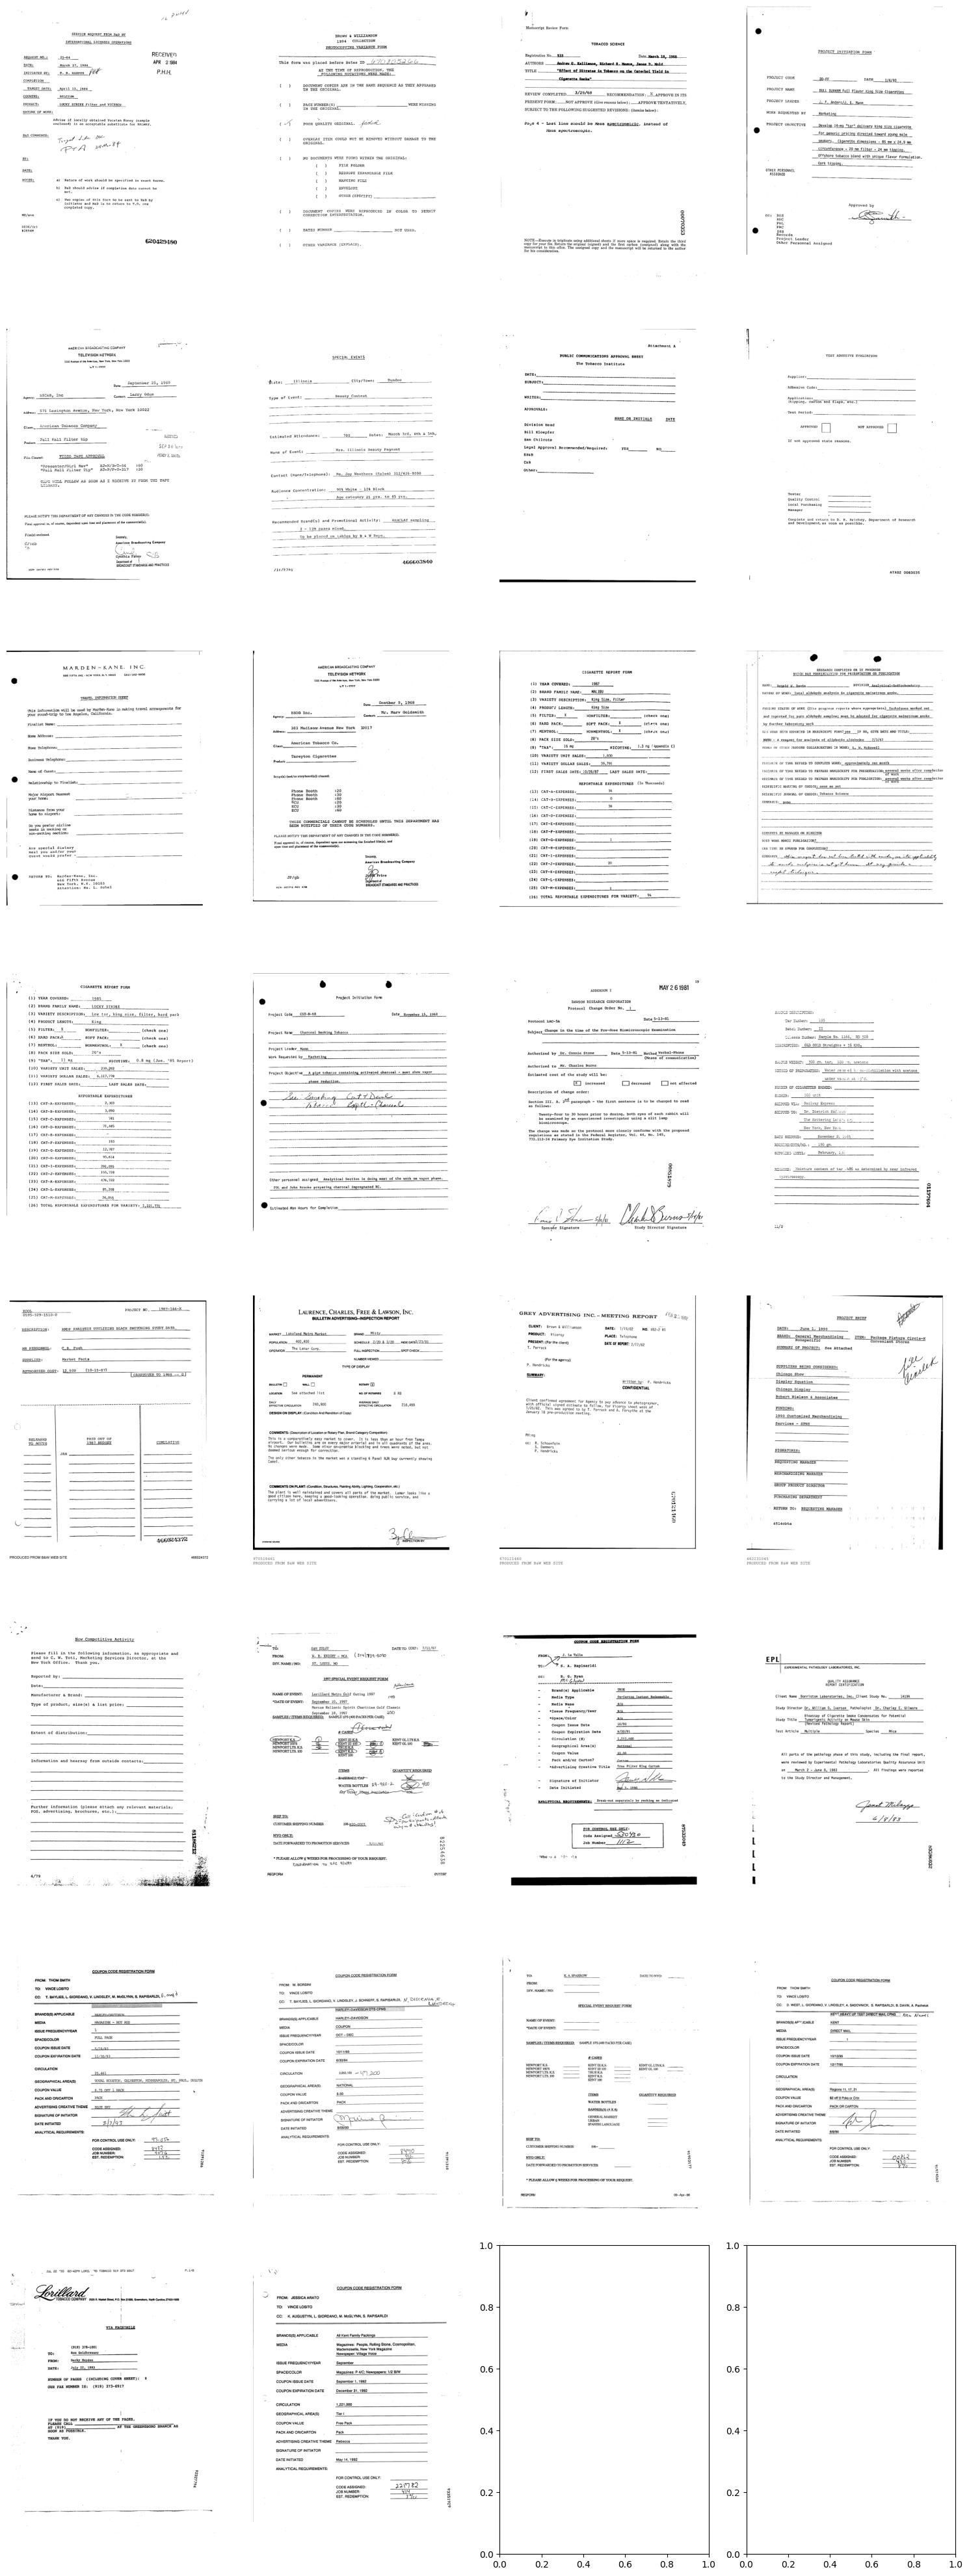

Group 1: 2 images


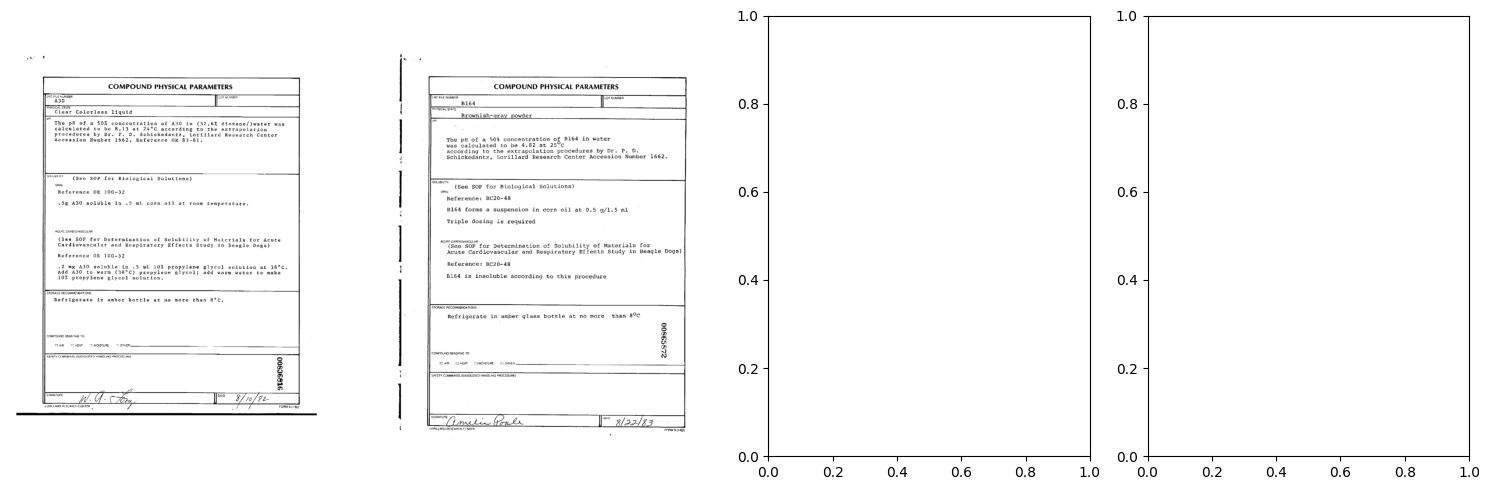

Group 2: 2 images


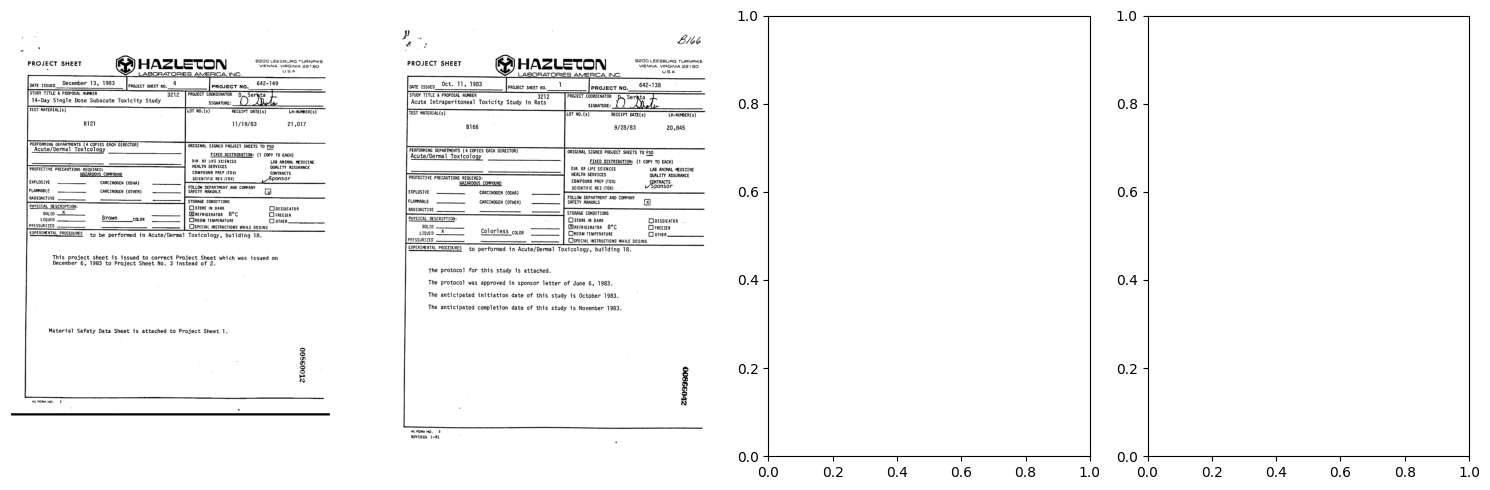

Group 3: 2 images


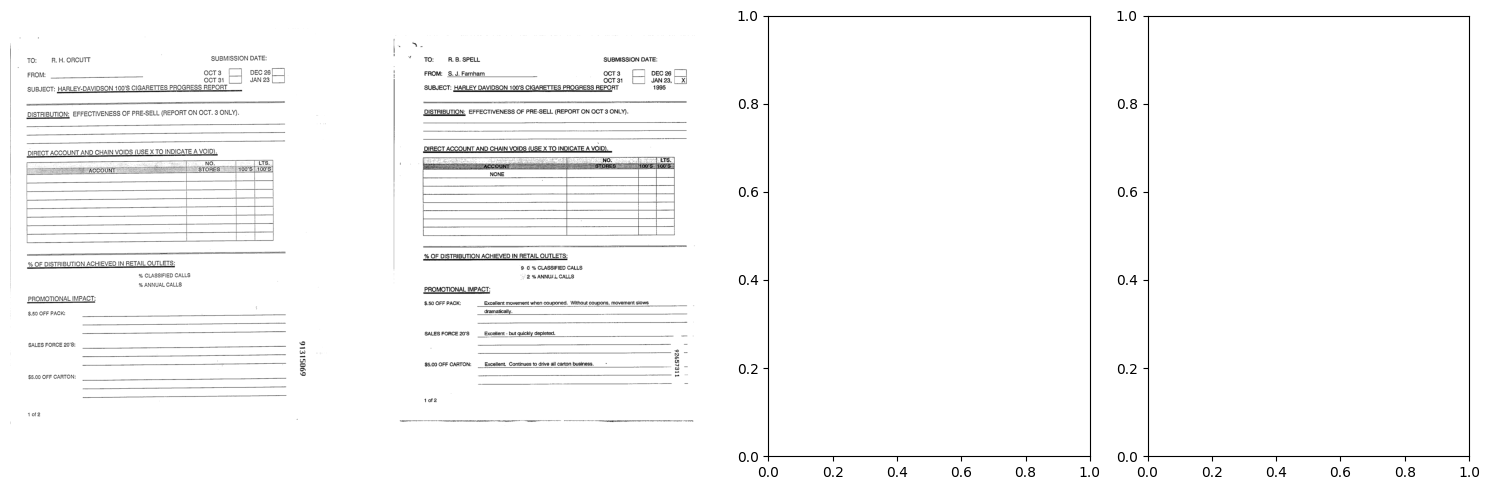

Group 4: 3 images


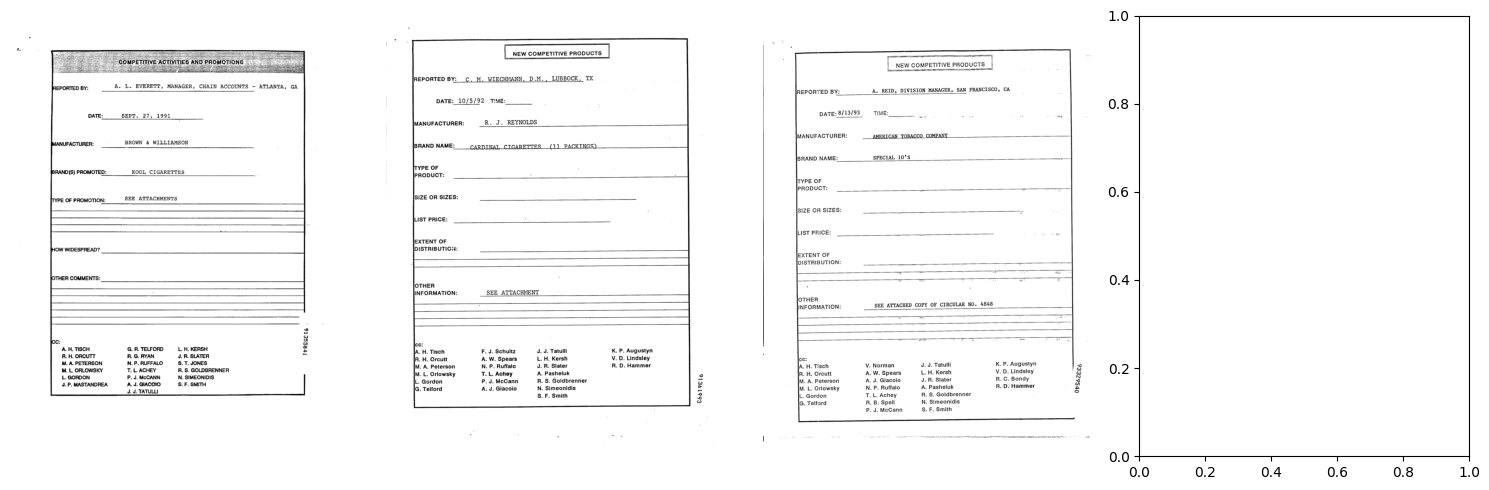

Group 5: 2 images


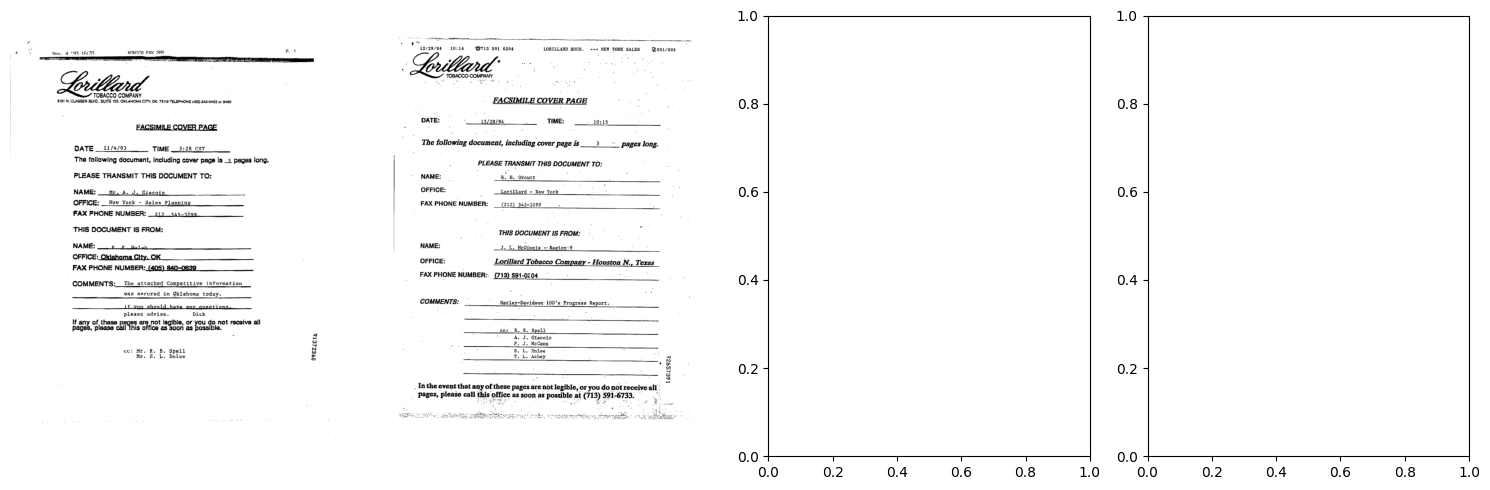

Group 6: 2 images


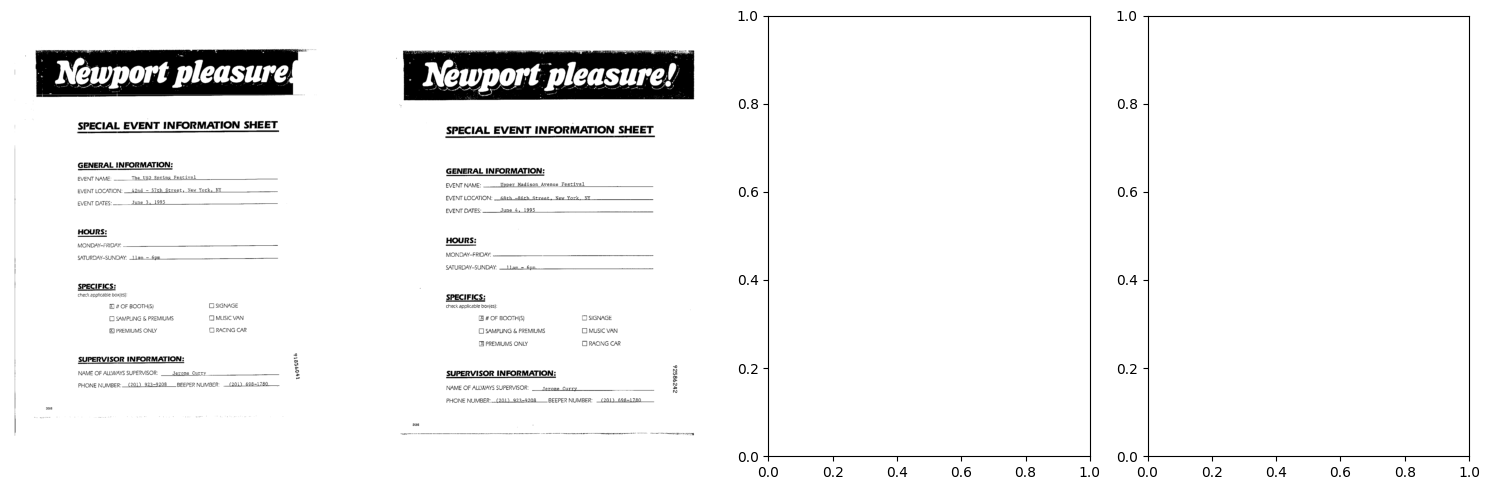

Group 7: 2 images


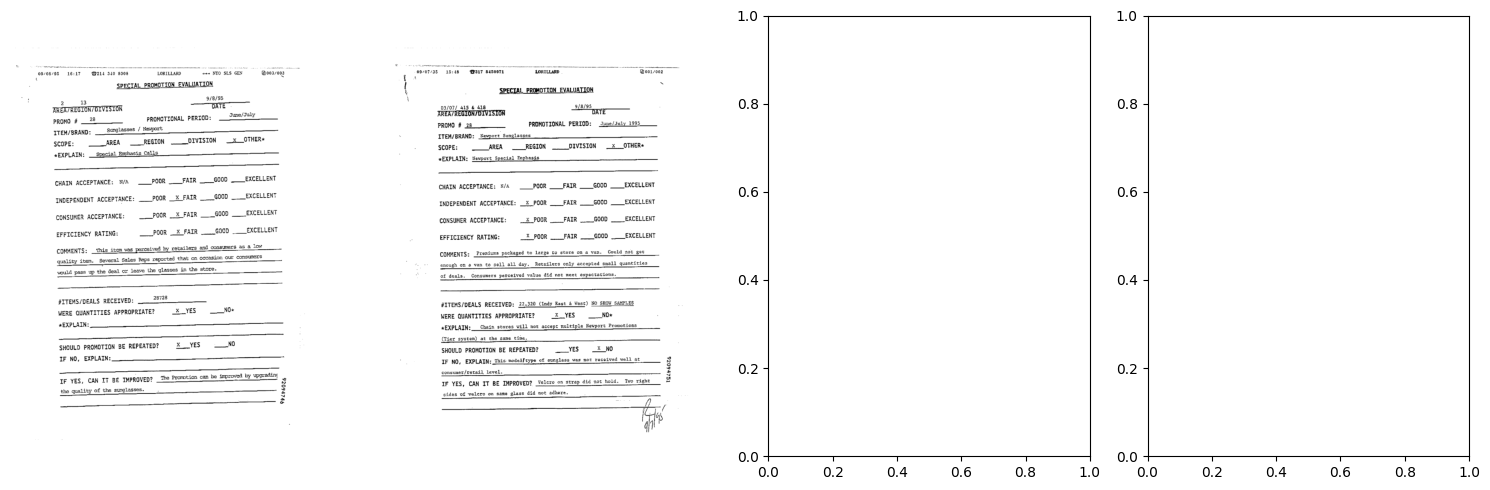

In [4]:
import cv2
import numpy as np
import os
from sklearn.cluster import DBSCAN
from collections import defaultdict
import matplotlib.pyplot as plt

def feature_based_grouping_and_display(image_dir, min_samples=1):
    # ORB keypoint detector
    orb = cv2.ORB_create()
    # Create matcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    image_features = []
    image_paths = []

    # Detect features and compute descriptors for each image
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        keypoints, descriptors = orb.detectAndCompute(img, None)
        image_features.append((img_name, descriptors))
        image_paths.append(img_path)

    # Match descriptors between images and count good matches
    match_counts = np.zeros((len(image_features), len(image_features)))
    for i, (_, desc1) in enumerate(image_features):
        for j, (_, desc2) in enumerate(image_features):
            if i != j and desc1 is not None and desc2 is not None:
                matches = bf.match(desc1, desc2)
                # Apply a threshold to select 'good' matches
                good_matches = [m for m in matches if m.distance < 50]
                match_counts[i, j] = len(good_matches)

    # Clustering
    clustering = DBSCAN(min_samples=min_samples, metric="precomputed").fit(1 - (match_counts / np.max(match_counts)))
    groups = defaultdict(list)
    for idx, label in enumerate(clustering.labels_):
        if label != -1:
            groups[label].append(image_paths[idx])

    # Display grouped images using matplotlib
    for label, group_paths in groups.items():
        print(f"Group {label}: {len(group_paths)} images")
        columns = 4
        rows = int(np.ceil(len(group_paths) / columns))
        fig, axarr = plt.subplots(rows, columns, figsize=(15, rows * 5))
        for idx, img_path in enumerate(group_paths):
            img = plt.imread(img_path)
            ax = axarr.flatten()[idx] if rows > 1 else axarr[idx]
            ax.imshow(img, cmap='gray')
            ax.axis('off')
        plt.tight_layout()
        plt.show()

# Example usage
image_directory = "C:\\Users\\arpit\\Desktop\\UG\\Masters\\Datasets\\FUNSD\\training_data\\images"
feature_based_grouping_and_display(image_directory, min_samples=1)
